### Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from utils.models import model_mapping
from utils.evaluate import evaluate_model
from IPython.display import display, Markdown
from sklearn.exceptions import ConvergenceWarning

# suppressing OpenMP deprecation from LightGBM
os.environ["KMP_WARNINGS"] = "0"

# suppressing specific warnings by module filtering
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_selection._univariate_selection")
warnings.filterwarnings("ignore", category=UserWarning, module="umap.umap_")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Usage of np.ndarray subset.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite' was renamed.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered in divide.*")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# you could suppress ALL UserWarnings and RuntimeWarnings, but we might miss something (so let's not)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading Best Models

In [2]:
# configuration
dataset_names = ['rarefied', 'clr']
data_dir = "./data"
results_dir = "./results/summaries"
clr_visuals_dir = "./results/visuals/clr"
rarefied_visuals_dir = "./results/visuals/rarefied"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(clr_visuals_dir, exist_ok=True)
os.makedirs(rarefied_visuals_dir, exist_ok=True)

# loading best models info
with open(f"{results_dir}/best_models.json", "r") as f:
    best_models_dict = json.load(f)

print("Loaded Best Models from Training:")
for dataset, model_info in best_models_dict.items():
    print(f"- {dataset}: {model_info['best_model']} (AUC = {model_info['metrics']['auc']})")

Loaded Best Models from Training:
- rarefied: Light Gradient Boosting Model (AUC = 0.78108)
- clr: Gradient Boosting (AUC = 0.77415)


### Loading Best Models & Defining Feature Selection & Extraction Utility Functions

In [3]:
def select_features(X_train, y_train, X_test, method, k=100):
    selector = SelectKBest(method, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected
    
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

### Feature Engineering Function

In [4]:
def run_feature_engineering(dataset_name):
    print(f"\n{'='*60}\n Running Feature Engineering on: {dataset_name}\n{'='*60}")
    
    df = pd.read_csv(f"{data_dir}/{dataset_name}.csv", index_col=0)
    X = df.drop(columns=["Diagnosis", "Diagnosis_labeled"])
    y = df["Diagnosis_labeled"]
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    vt = VarianceThreshold(threshold=0)
    X = vt.fit_transform(X)
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    best_model_name = best_models_dict[dataset_name]["best_model"]
    if best_model_name not in model_mapping:
        raise ValueError(f"Model '{best_model_name}' not found in model_mapping")
    
    best_model = model_mapping[best_model_name]() 
    feature_counts = [1] + list(range(10, 201, 10)) # official
    #feature_counts = [1, 50, 100, 200] # for temporary convenience
    feature_selection_results = {}
    feature_extraction_results = {}

    # baseline
    print("- Evaluating Baseline Model (All Features)")
    best_model.train(X_train, y_train)
    baseline_pred_probs = best_model.model.predict_proba(X_test)[:, 1]
    baseline_results = evaluate_model(y_test, baseline_pred_probs.round(), baseline_pred_probs)

    # feature selection
    print("- Evaluating Feature Selection Methods:")
    for k in tqdm(feature_counts):

        X_train_chi2, X_test_chi2 = select_features(X_train, y_train, X_test, chi2, k)
        X_train_mi, X_test_mi = select_features(X_train, y_train, X_test, mutual_info_classif, k)
        X_train_anova, X_test_anova = select_features(X_train, y_train, X_test, f_classif, k)
        
        best_model.train(X_train_chi2, y_train)
        chi2_probs = best_model.model.predict_proba(X_test_chi2)[:, 1]
        
        best_model.train(X_train_mi, y_train)
        mi_probs = best_model.model.predict_proba(X_test_mi)[:, 1]

        best_model.train(X_train_anova, y_train)
        anova_probs = best_model.model.predict_proba(X_test_anova)[:, 1]

        feature_selection_results[k] = {
            "Chi-Squared": {**evaluate_model(y_test, chi2_probs.round(), chi2_probs),
                           "y_probs": chi2_probs},
            "Mutual Information": {**evaluate_model(y_test, mi_probs.round(), mi_probs),
                                   "y_probs": mi_probs},
            "ANOVA F-value": {**evaluate_model(y_test, anova_probs.round(), anova_probs),
                              "y_probs": anova_probs}
        }
        
    # feature extraction
    print("- Evaluating Feature Extraction Methods:")
    for n in tqdm(feature_counts):
        
        X_train_pca, X_test_pca = apply_pca(X_train, X_test, n)
        kpca = KernelPCA(n_components=n, kernel='rbf')
        X_train_kpca = kpca.fit_transform(X_train)
        X_test_kpca = kpca.transform(X_test)

        umap_reducer = umap.UMAP(n_components=n, random_state=42)
        X_train_umap = umap_reducer.fit_transform(X_train)
        X_test_umap = umap_reducer.transform(X_test)
        
        best_model.train(X_train_pca, y_train)
        pca_probs = best_model.model.predict_proba(X_test_pca)[:, 1]
        
        best_model.train(X_train_kpca, y_train)
        kpca_probs = best_model.model.predict_proba(X_test_kpca)[:, 1]
        
        best_model.train(X_train_umap, y_train)
        umap_probs = best_model.model.predict_proba(X_test_umap)[:, 1]

        feature_extraction_results[n] = {
            "UMAP": {**evaluate_model(y_test, umap_probs.round(), umap_probs),
                     "y_probs": umap_probs},
            "PCA": {**evaluate_model(y_test, pca_probs.round(), pca_probs),
                    "y_probs": pca_probs},
            "Kernel PCA": {**evaluate_model(y_test, kpca_probs.round(), kpca_probs),
                           "y_probs": kpca_probs}
        }

    # save results to csv
    metric_names = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
    def expand(results_dict, method_type):
        return {
            (k, method_type, method): metrics
            for k, v in results_dict.items() for method, metrics in v.items()
        }
        
    df_results = pd.DataFrame.from_dict(
        {**expand(feature_selection_results, "Selection"),
         **expand(feature_extraction_results, "Extraction")},
        orient='index', columns=metric_names
    )
    df_results.index = pd.MultiIndex.from_tuples(df_results.index, names=["# Features", "Type", "Method"])
    df_results.loc[("All Features", "Baseline", best_model_name)] = baseline_results
        
    df_results.to_csv(f"{results_dir}/feature_eng_results_{dataset_name}.csv")
    print(f"\nSaved feature engineering results for {dataset_name} to results folder.")
    
    return {
        "y_test": y_test,
        "baseline_probs": baseline_pred_probs,
        "feature_selection": feature_selection_results,
        "feature_extraction": feature_extraction_results,
        "best_model_name": best_model_name
    }

### Run Feature Engineering & Store Results

In [5]:
feature_eng_outputs = {}

for ds in dataset_names: 
    feature_eng_outputs[ds] = run_feature_engineering(ds)



 Running Feature Engineering on: rarefied
- Evaluating Baseline Model (All Features)
- Evaluating Feature Selection Methods:


100%|███████████████████████████████████████████| 21/21 [02:05<00:00,  5.97s/it]


- Evaluating Feature Extraction Methods:


100%|███████████████████████████████████████████| 21/21 [00:52<00:00,  2.52s/it]



Saved feature engineering results for rarefied to results folder.

 Running Feature Engineering on: clr
- Evaluating Baseline Model (All Features)
- Evaluating Feature Selection Methods:


100%|███████████████████████████████████████████| 21/21 [03:24<00:00,  9.76s/it]


- Evaluating Feature Extraction Methods:


100%|███████████████████████████████████████████| 21/21 [01:30<00:00,  4.32s/it]


Saved feature engineering results for clr to results folder.


### Summary Results

In [6]:
def print_summary_table(dataset_name):
    df = pd.read_csv(f"{results_dir}/feature_eng_results_{dataset_name}.csv", index_col=[0,1,2])
    display(Markdown(f"### Summary of Feature Engineering Results – `{dataset_name}` Dataset"))
    display(df.style.highlight_max(axis=0, color='lightgreen'))
    display(Markdown("_Note: Best score for each method (Chi², MI, PCA, etc.) is highlighted across different feature counts._"))
    return df

df_rarefied = print_summary_table("rarefied")
df_clr = print_summary_table("clr")

### Summary of Feature Engineering Results – `rarefied` Dataset

_Note: Best score for each method (Chi², MI, PCA, etc.) is highlighted across different feature counts._

### Summary of Feature Engineering Results – `clr` Dataset

_Note: Best score for each method (Chi², MI, PCA, etc.) is highlighted across different feature counts._

### Heatmap Function

In [7]:
def plot_heatmap(df, dataset_name):
    metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
    
    for metric in metrics:
        heatmap_data = df[df.index.get_level_values("# Features") != "All Features"]
        heatmap_data = heatmap_data[metric].unstack(level=[1, 2])
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".3f", linewidths=0.5)
        plt.title(f"{metric} Heatmap – {dataset_name}")
        plt.xlabel("Feature Engineering Methods")
        plt.ylabel("Number of Features")
        plt.tight_layout()
        visuals_dir = clr_visuals_dir if dataset_name == "clr" else rarefied_visuals_dir
        plt.savefig(f"{visuals_dir}/{dataset_name}_heatmap_{metric.lower()}.png")
        plt.show()

### Heatmaps -- Rarefaction

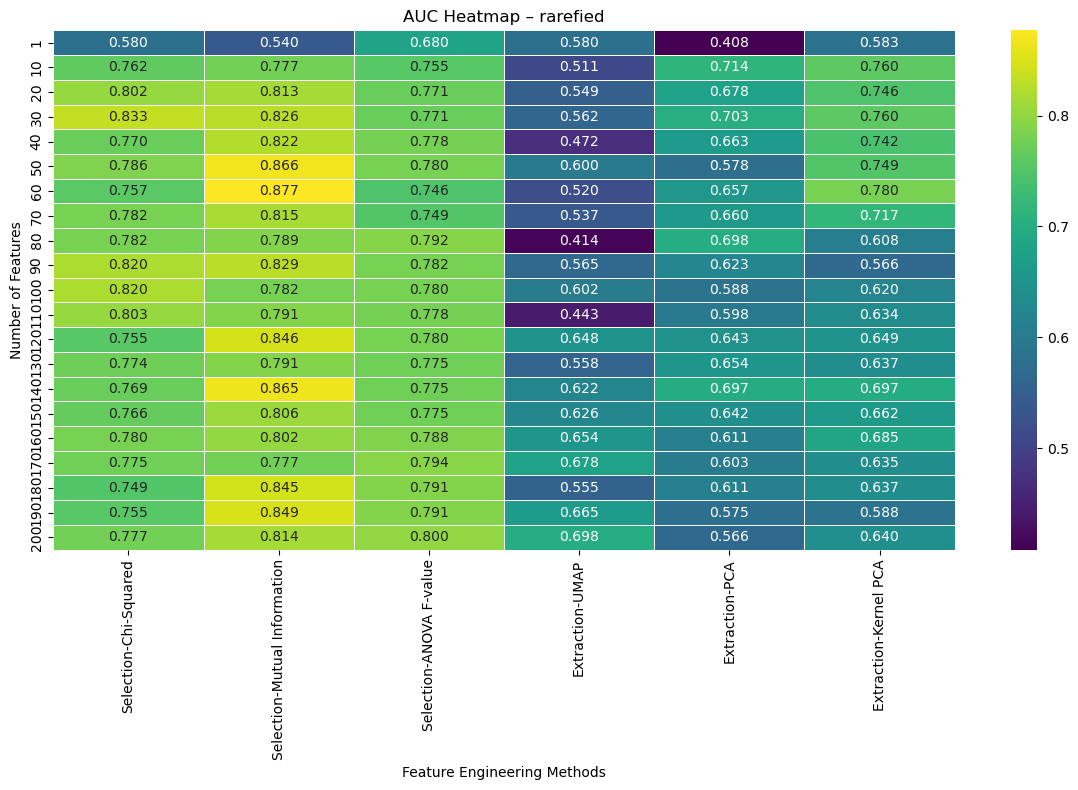

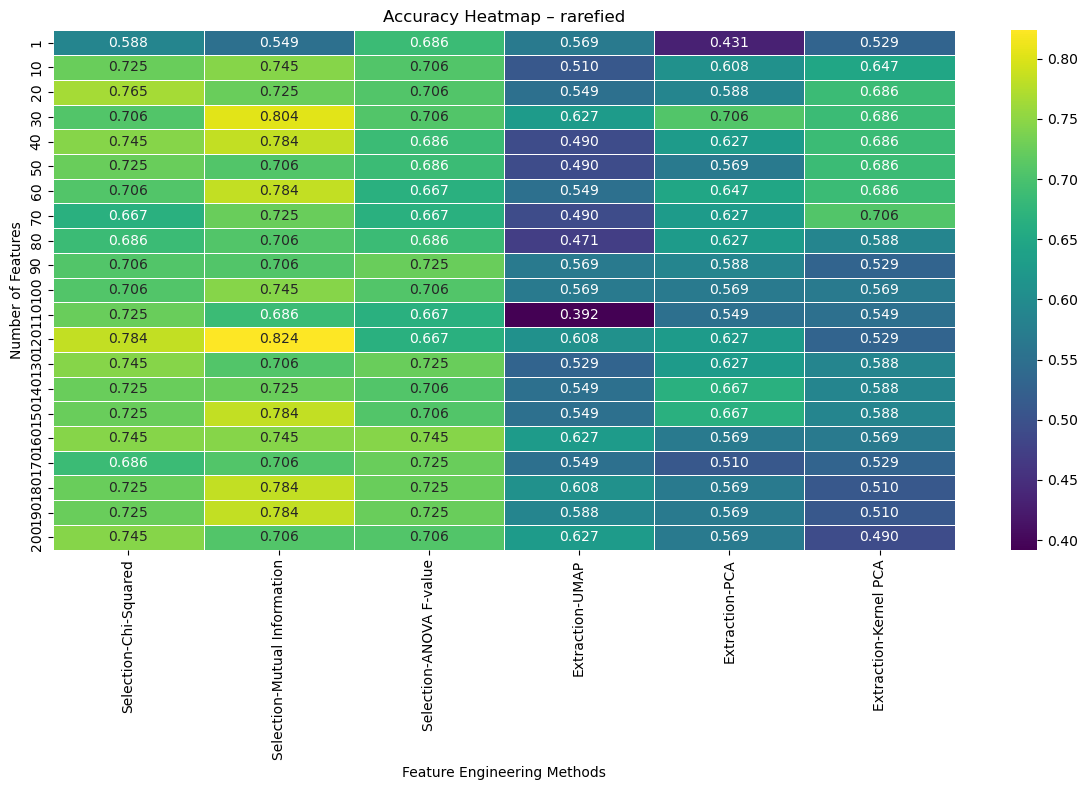

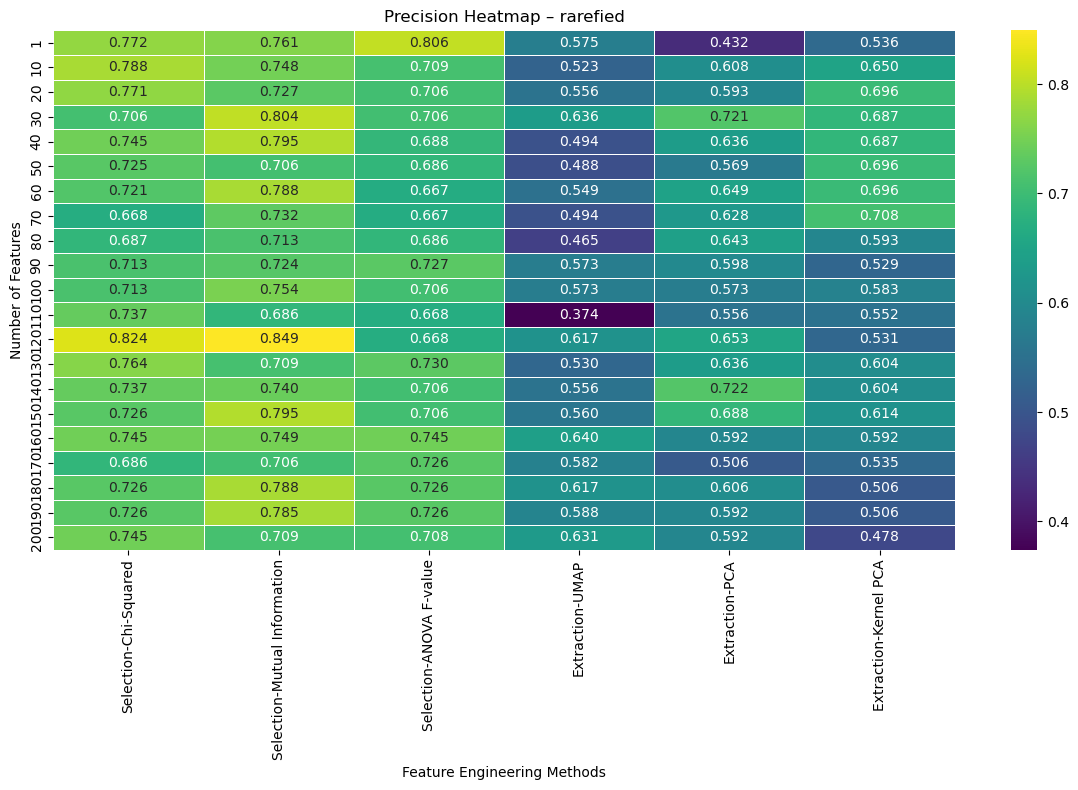

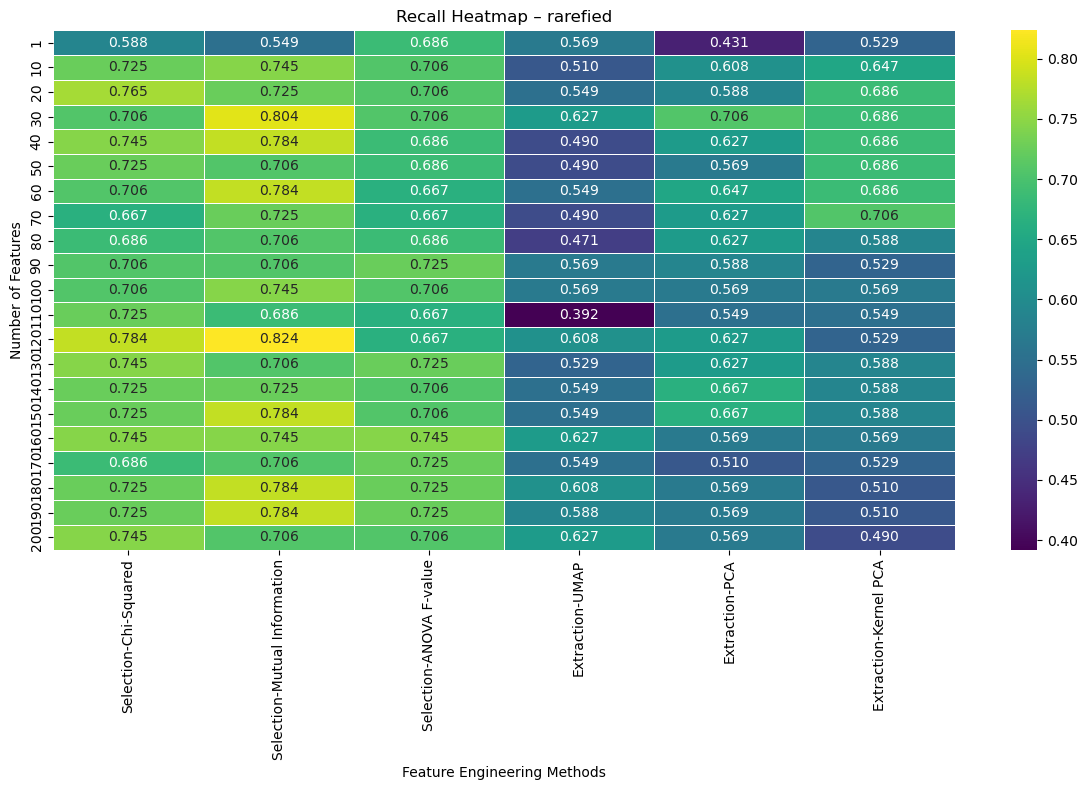

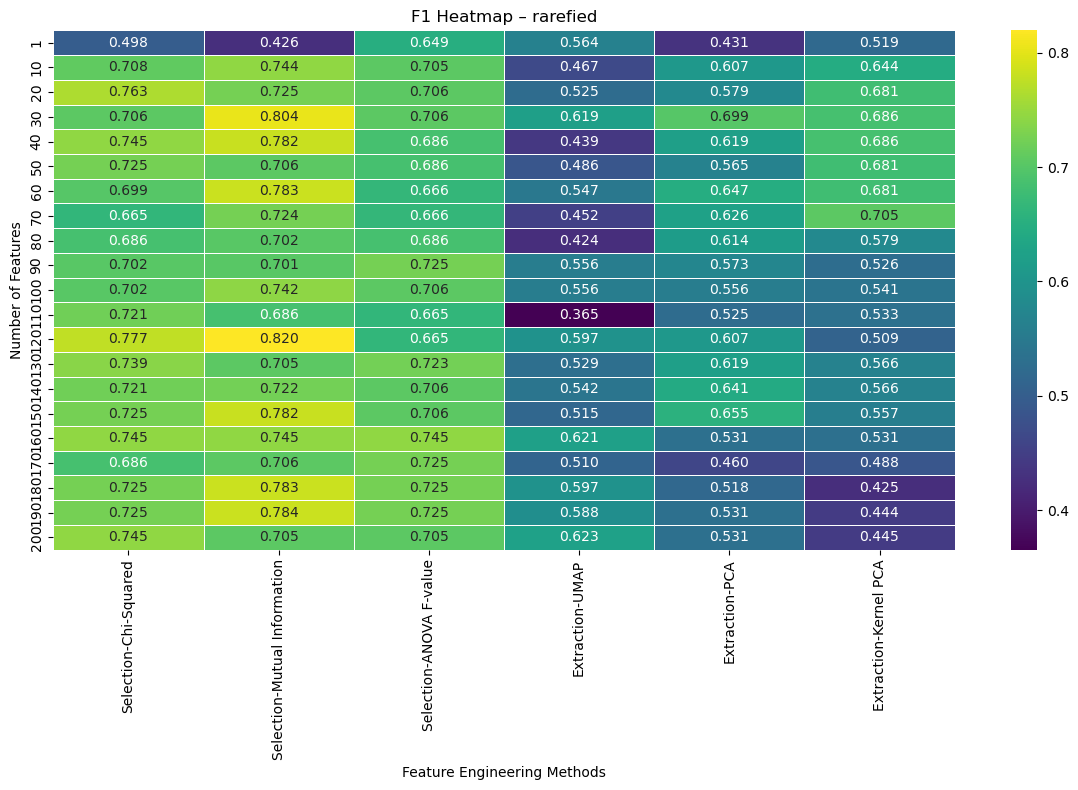

In [8]:
plot_heatmap(df_rarefied, "rarefied")

### Heatmaps -- CLR

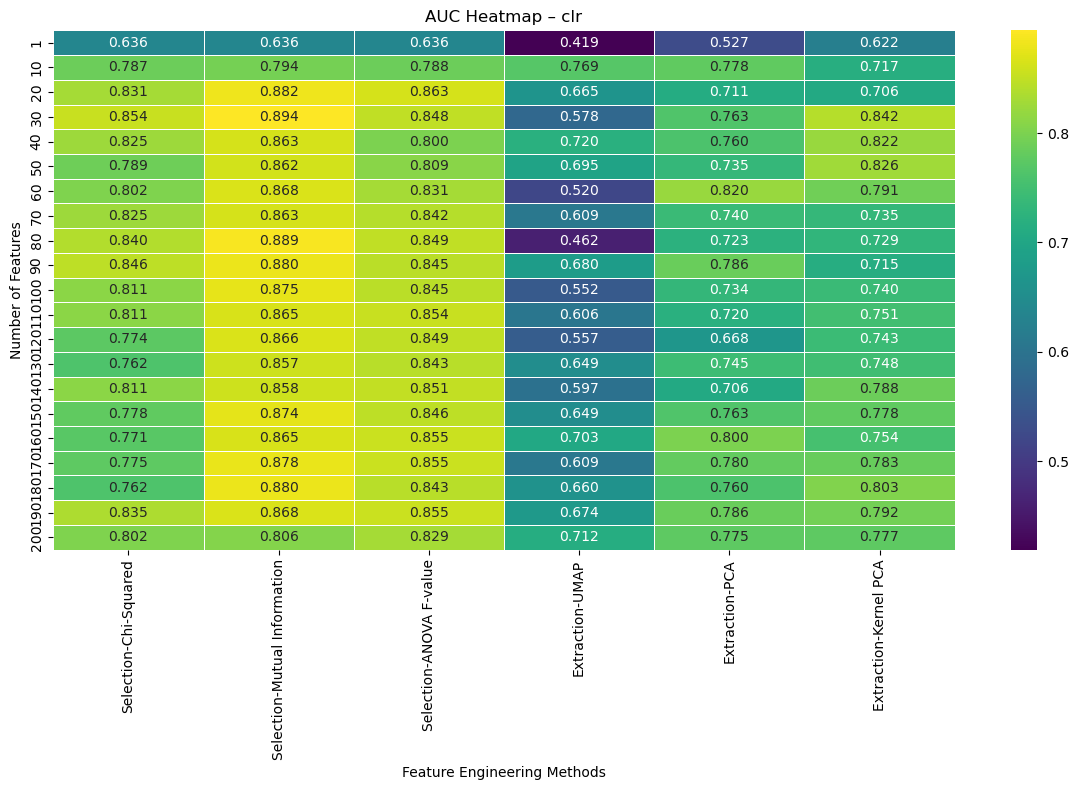

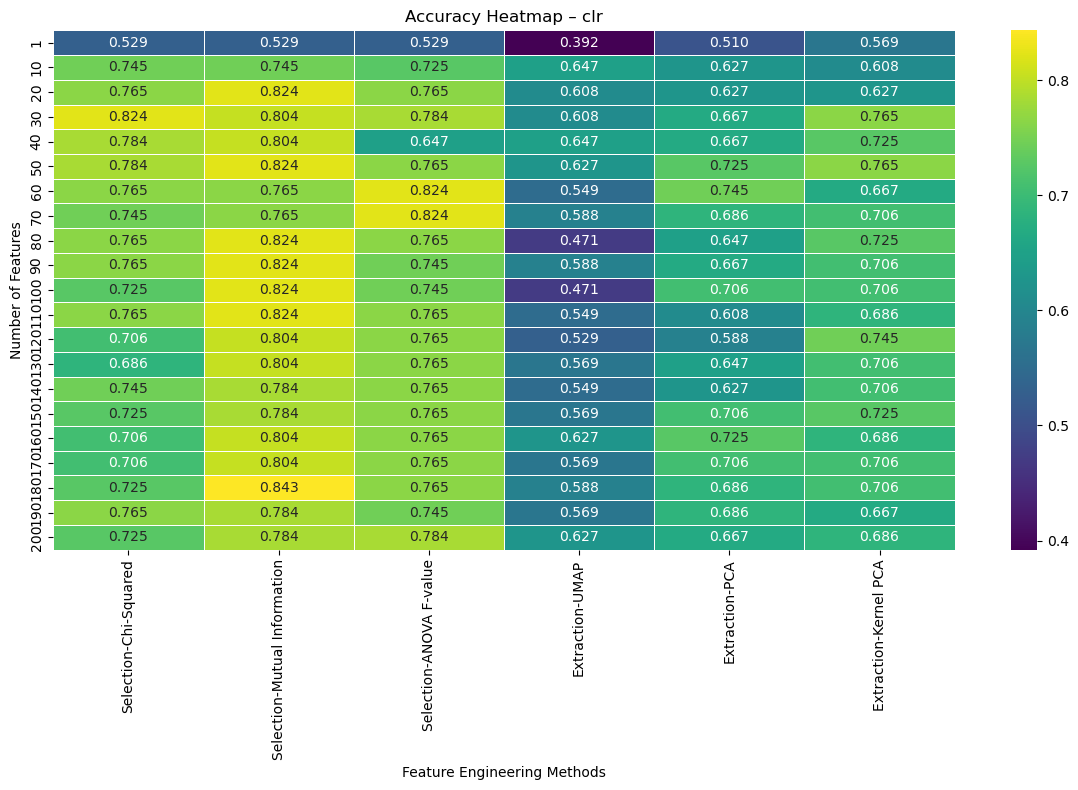

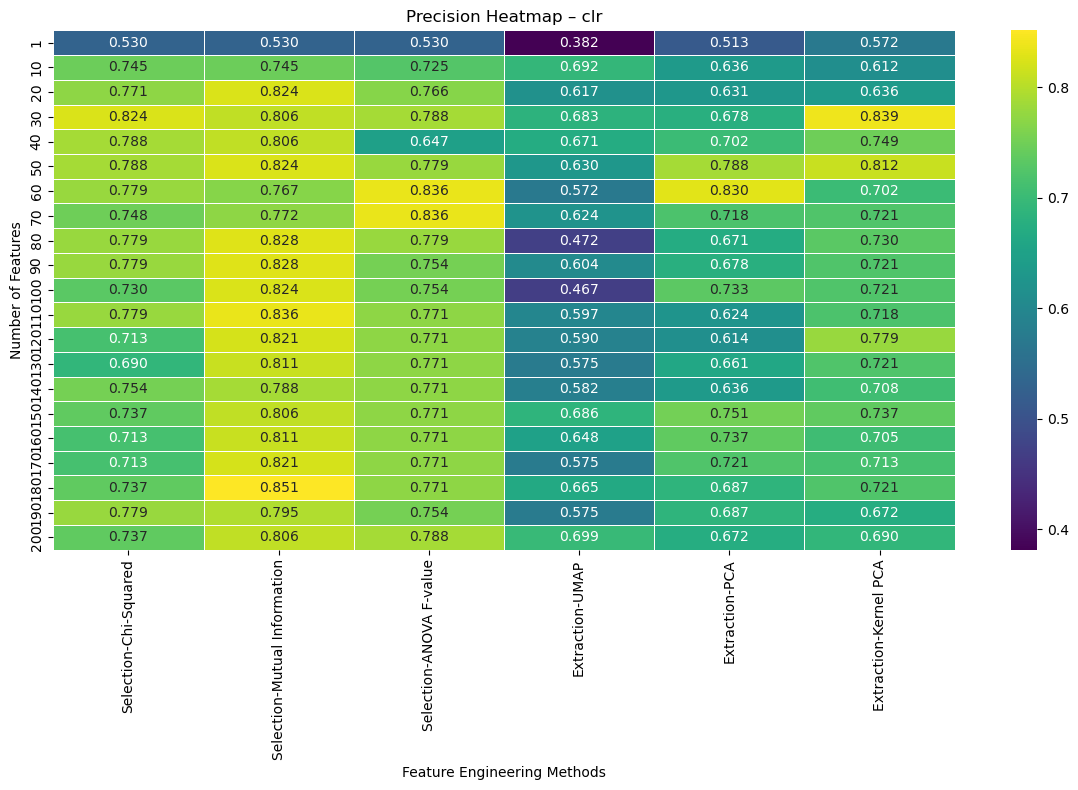

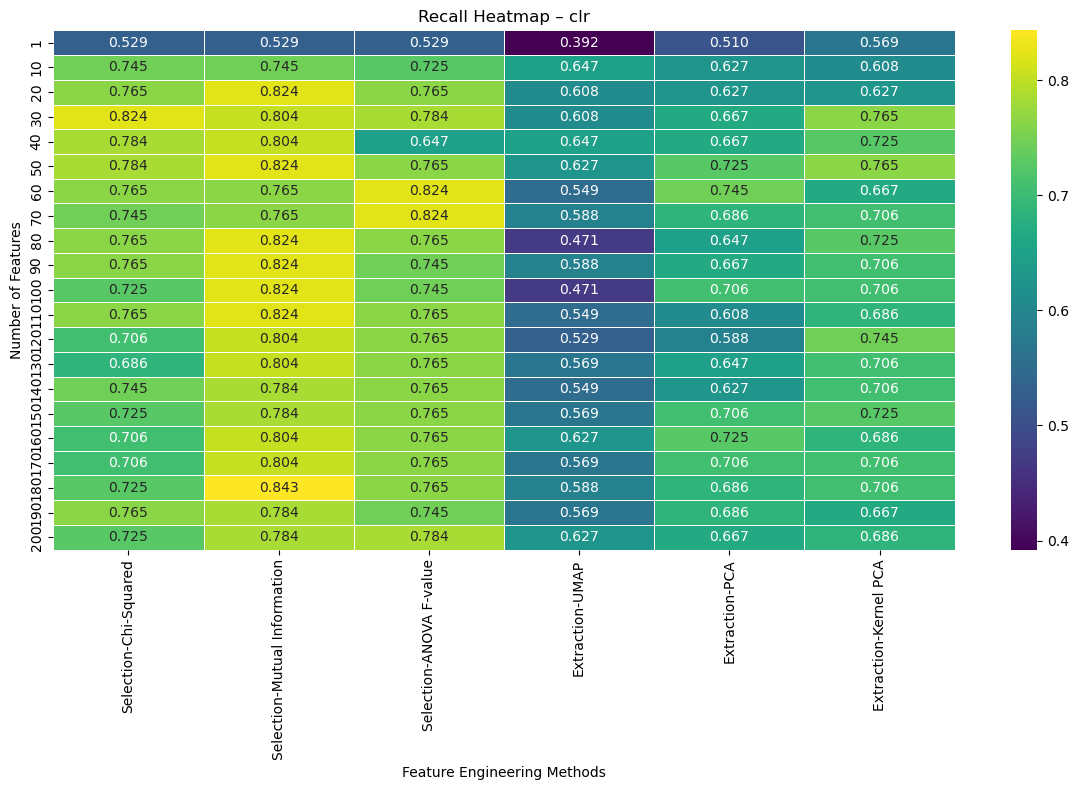

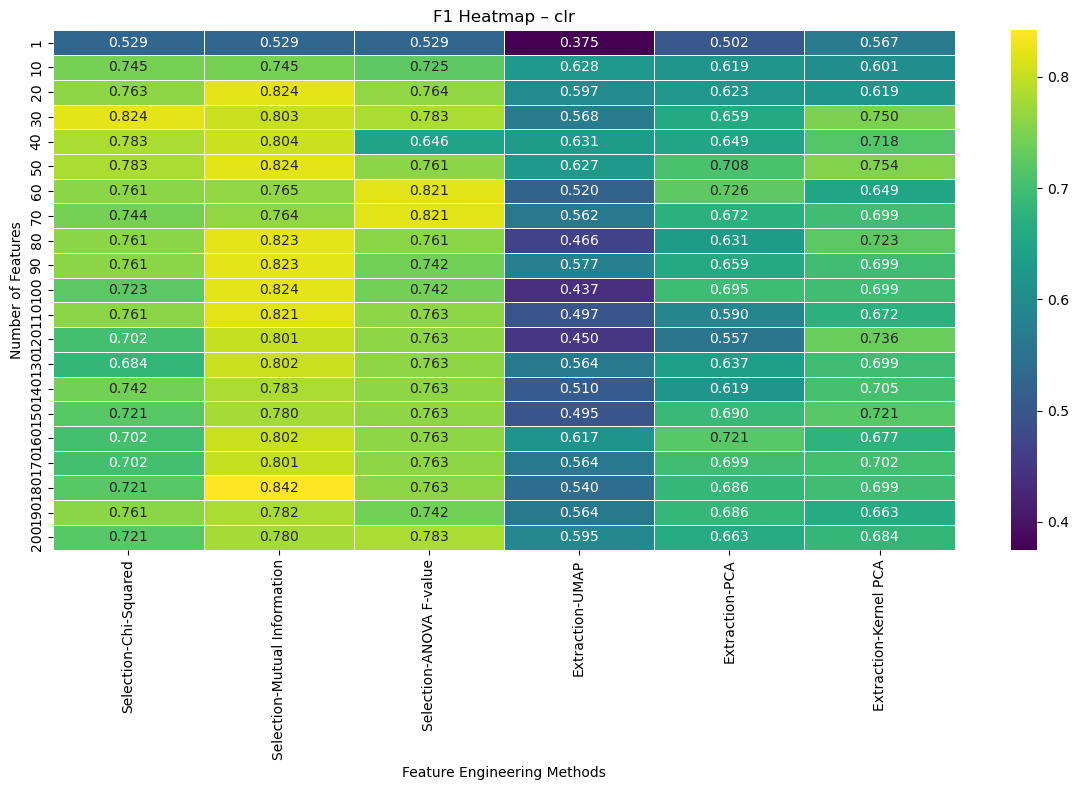

In [9]:
plot_heatmap(df_clr, "clr")

### Method Comparison Plotting Function

In [10]:
def plot_metric_trends(df, dataset_name, best_model_name):
    df_plot = df.reset_index()
    df_plot = df_plot[df_plot["# Features"] != "All Features"]
    
    metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
    feature_counts = sorted(df_plot["# Features"].unique())

    for metric in metrics:
        sns.set_palette("tab10")  # or "colorblind", "deep", etc.
        #plt.figure(figsize=(10, 6))
        plt.figure(figsize=(12, 8))
        #plt.figure(figsize=(14, 10))
        
        # plotting lines for each method
        sns.lineplot(
            data=df_plot,
            x="# Features",
            y=metric,
            hue="Method",
            style="Type",
            markers=True,
            dashes=False
        )

        # line for baseline
        baseline_value = df.xs(("All Features", "Baseline", best_model_name))[metric]
        '''
        plt.plot(
            feature_counts,
            [baseline_value] * len(feature_counts),
            linestyle="--",
            linewidth=2.5,
            color="red",
            label="Baseline - All Features"
        )
        '''
        plt.axhline(
            y=baseline_value,
            linestyle="--",
            color="red",
            label="Baseline - All Features"
        )
        
        plt.title(f"{metric} Scores ({dataset_name})")
        plt.xlabel("Number of Features")
        plt.ylabel(metric)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Methods")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        visuals_dir = clr_visuals_dir if dataset_name == "clr" else rarefied_visuals_dir
        plt.savefig(f"{visuals_dir}/{dataset_name}_trend_{metric.lower()}.png")
        plt.show()
    

### Feature Engineering Method Comparison — Rarefaction

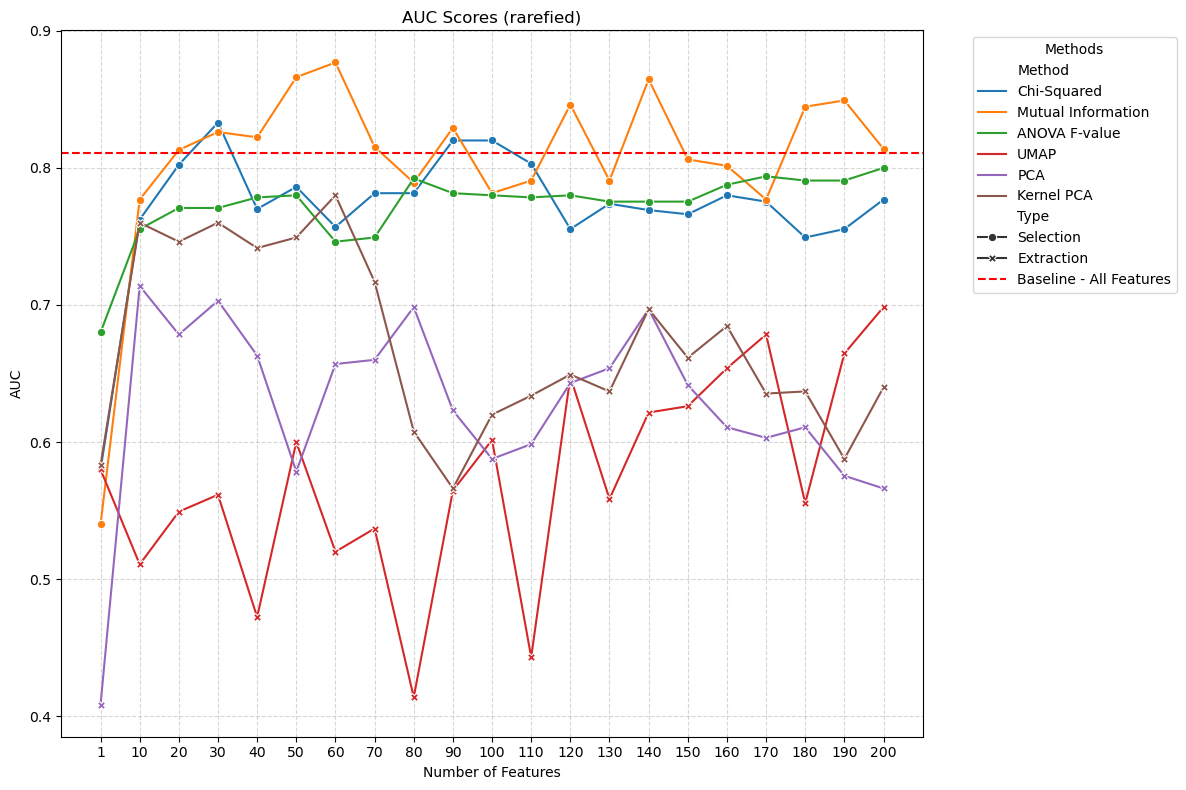

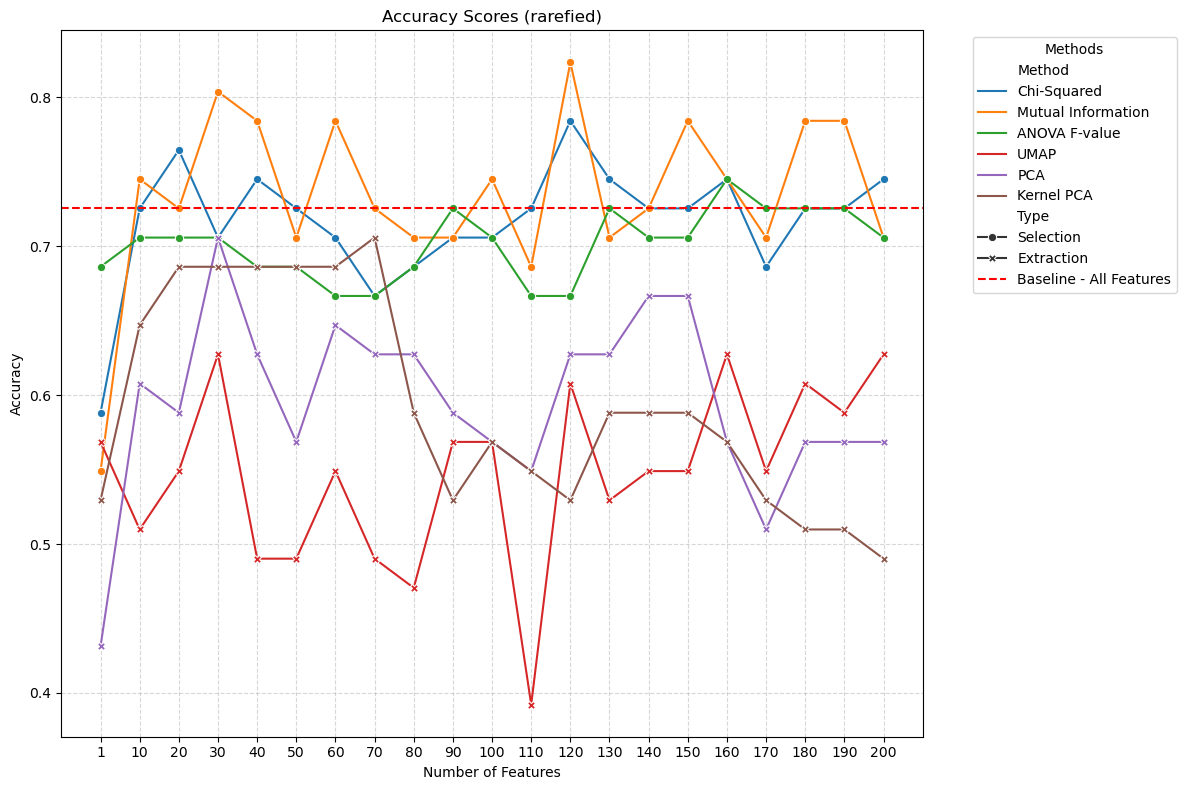

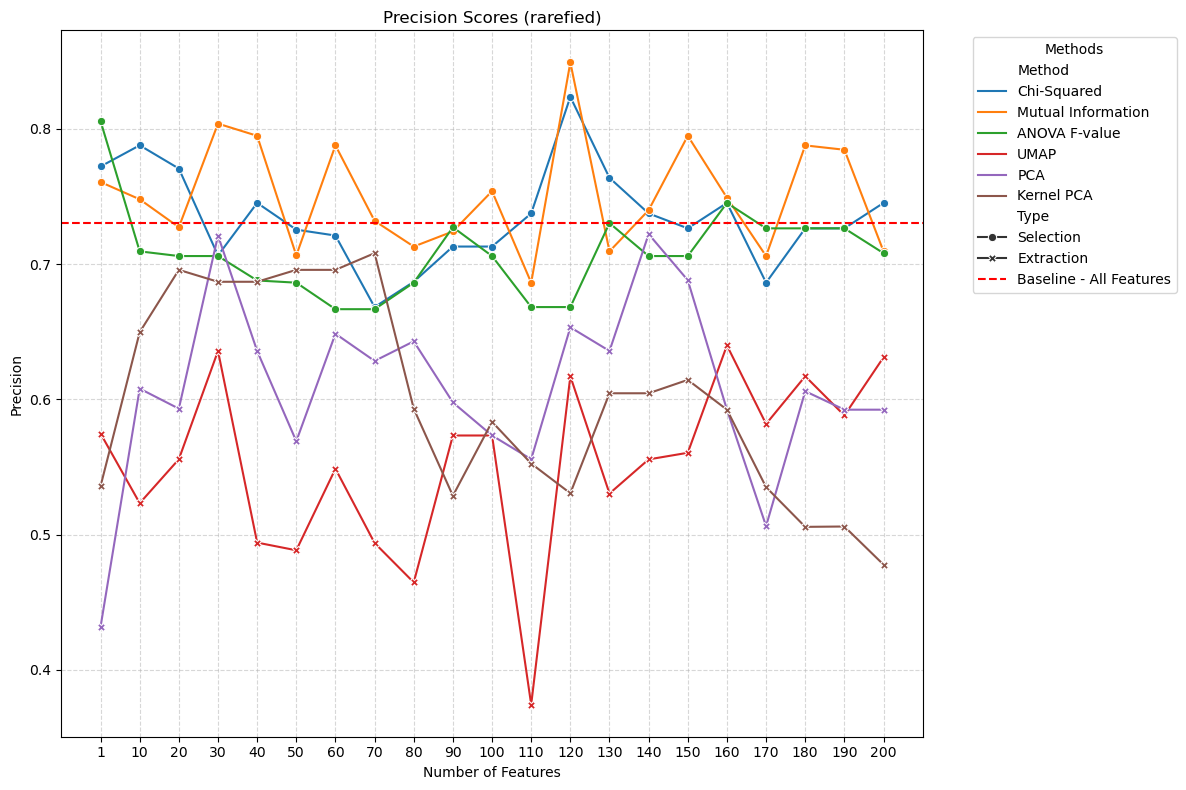

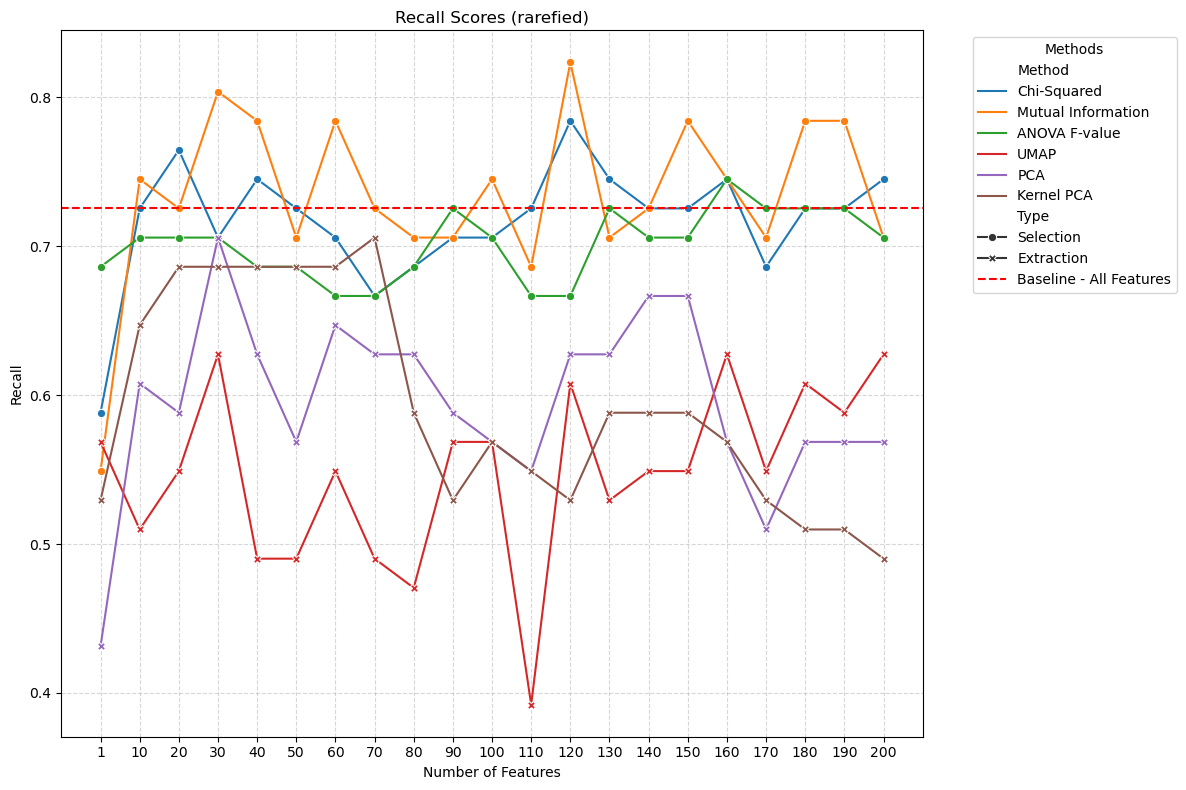

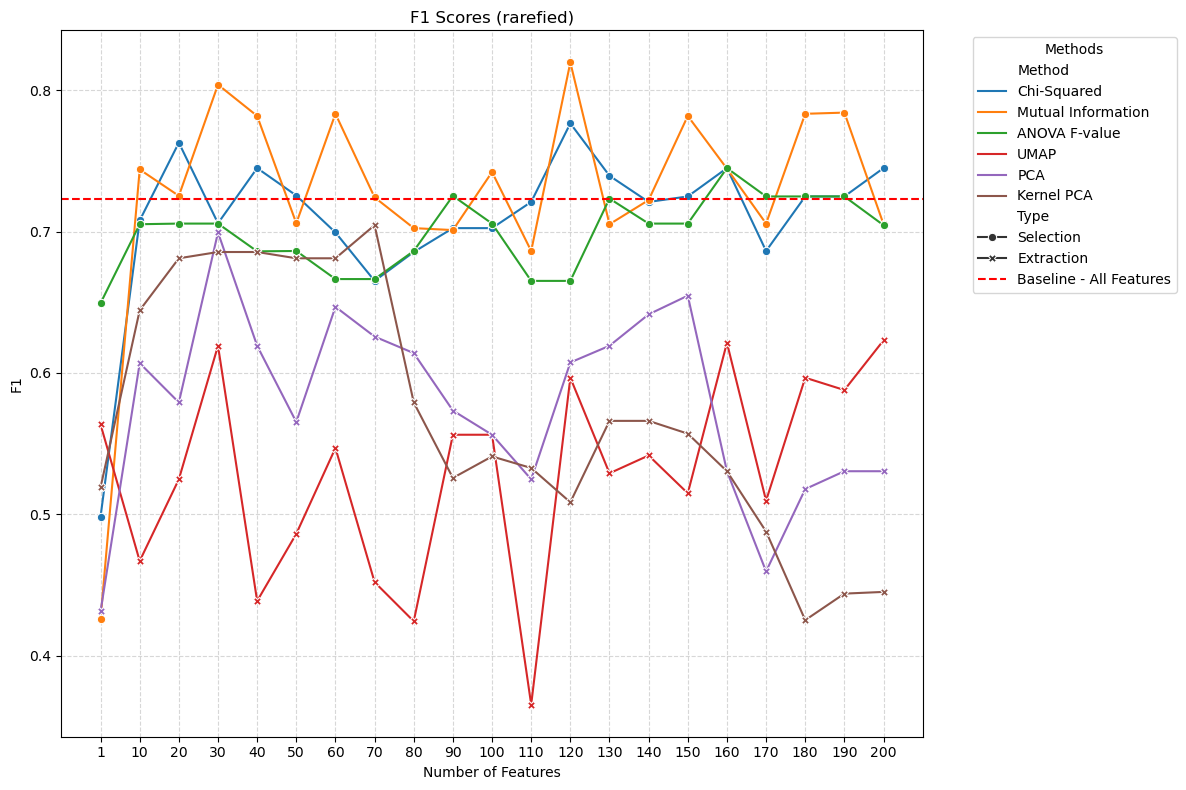

In [11]:
best_model_name = best_models_dict["rarefied"]["best_model"]
plot_metric_trends(df_rarefied, "rarefied", best_model_name)

### Feature Engineering Method Comparison — CLR

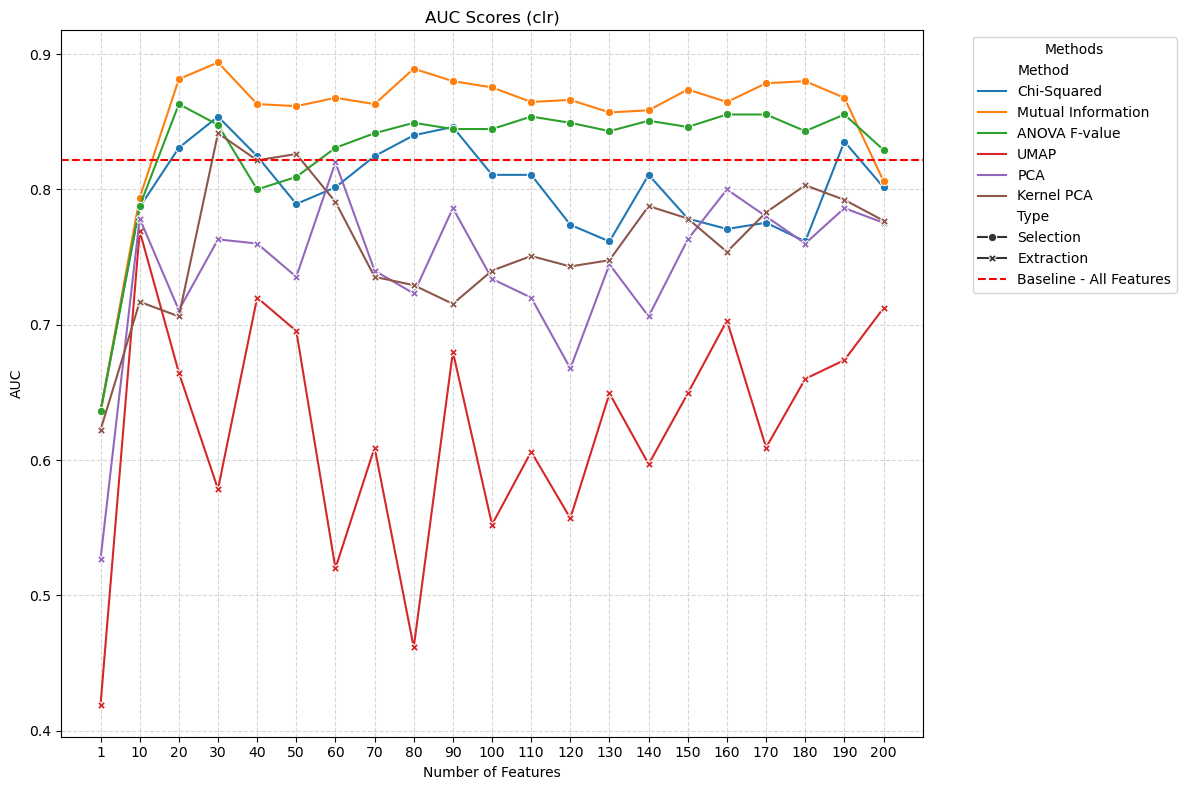

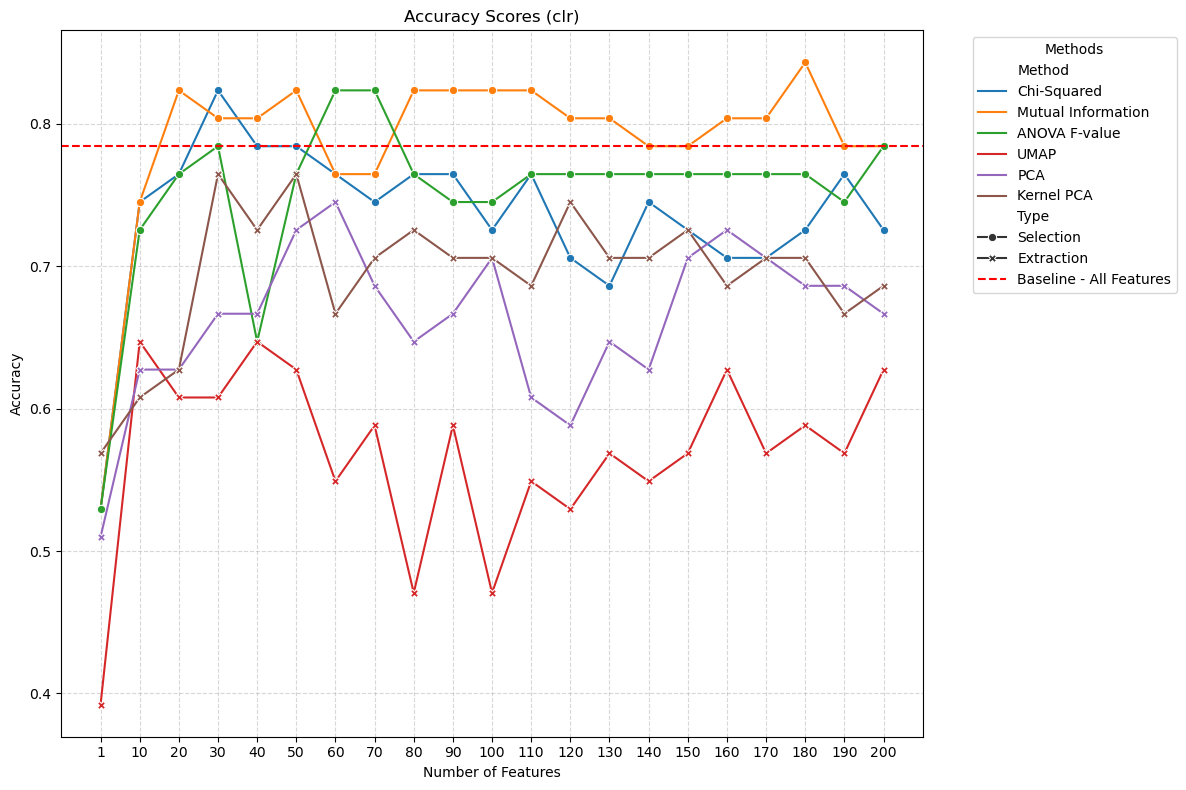

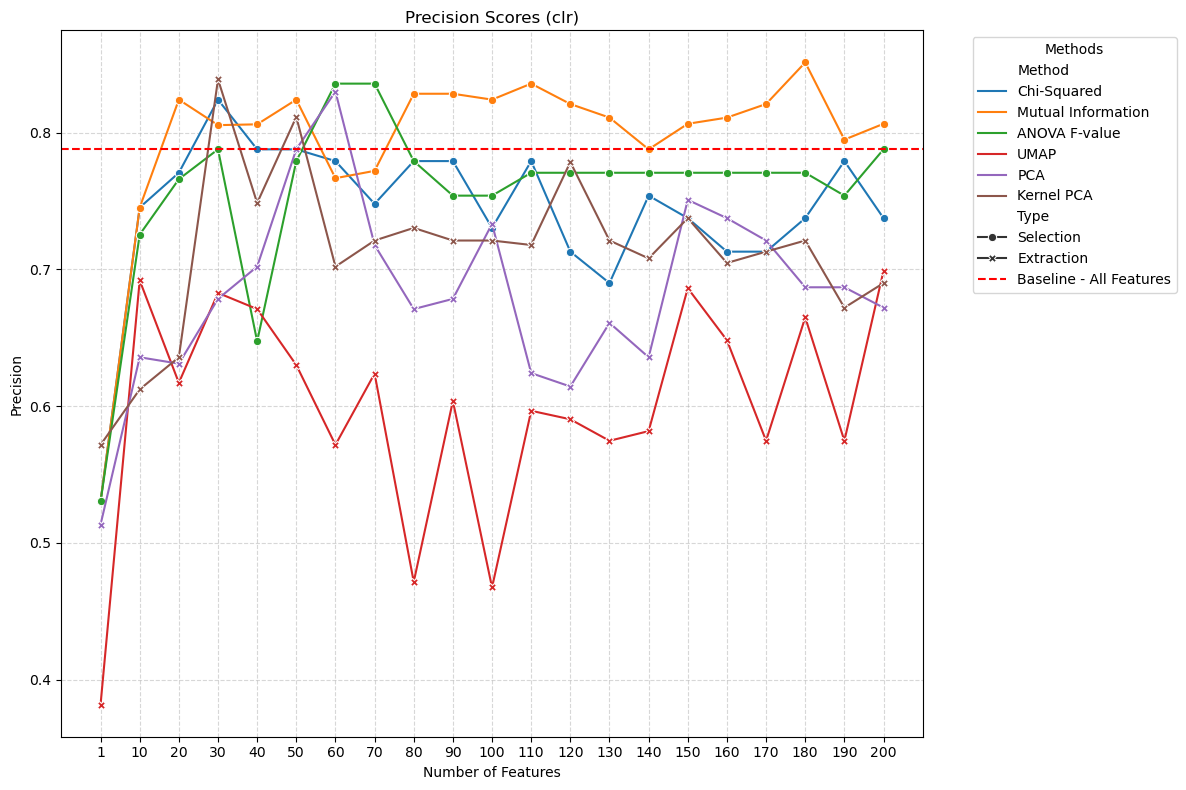

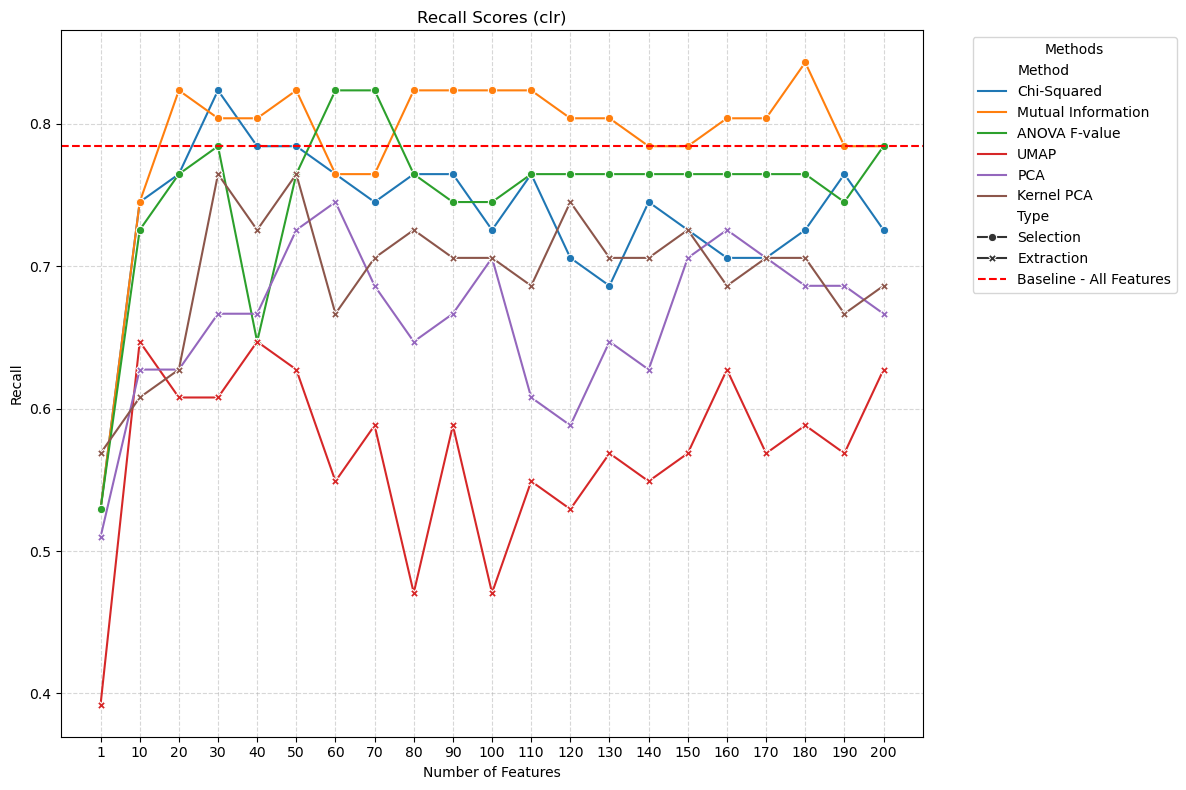

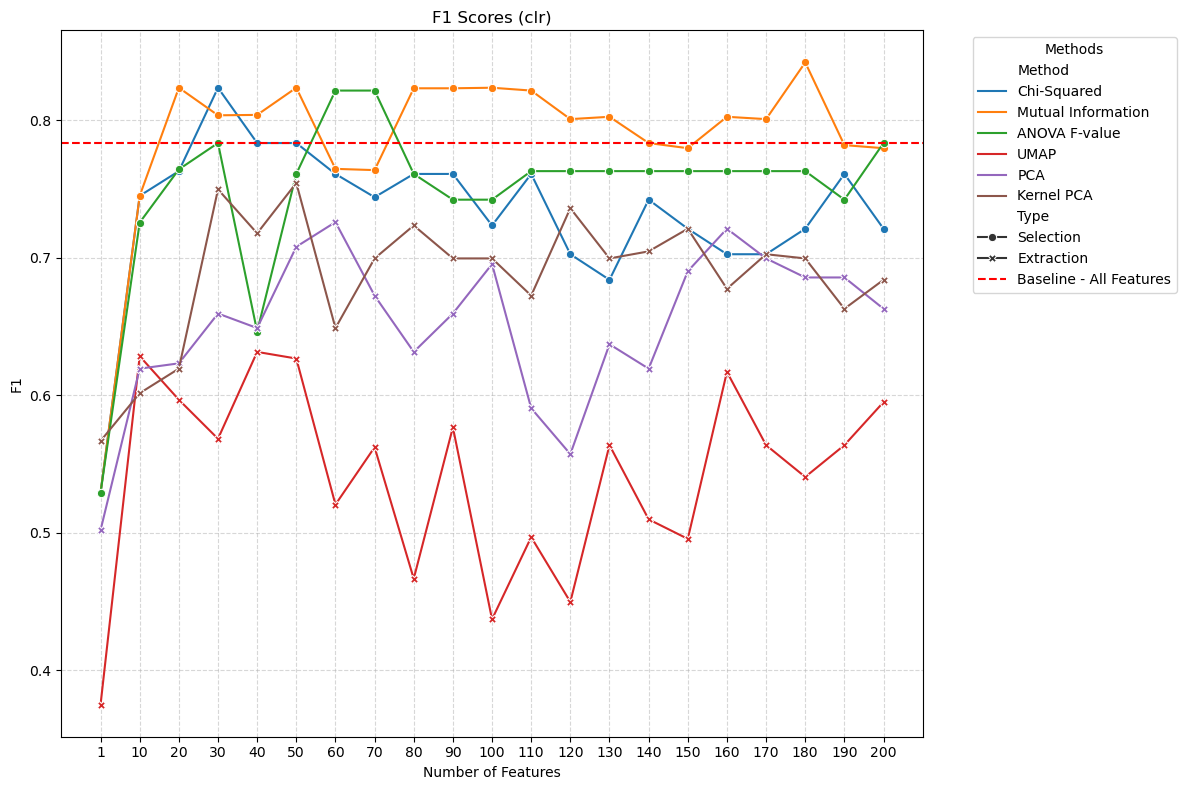

In [12]:
best_model_name = best_models_dict["clr"]["best_model"]
plot_metric_trends(df_clr, "clr", best_model_name)

### ROC Function

In [13]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_baseline_probs, y_best_probs, dataset_name, best_method_name):
    fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_baseline_probs)
    auc_baseline = auc(fpr_baseline, tpr_baseline)
    
    fpr_best, tpr_best, _ = roc_curve(y_test, y_best_probs)
    auc_best = auc(fpr_best, tpr_best)
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(fpr_best, tpr_best, label=f"{best_method_name} – AUC: {auc_best:.3f}")
    
    plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline (All Features) – AUC: {auc_baseline:.3f}")
    
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Characteristic (ROC) Curve – {dataset_name}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    visuals_dir = clr_visuals_dir if dataset_name == "clr" else rarefied_visuals_dir
    plt.savefig(f"{visuals_dir}/{dataset_name}_roc_curve.png")
    plt.show()

### ROC Curve

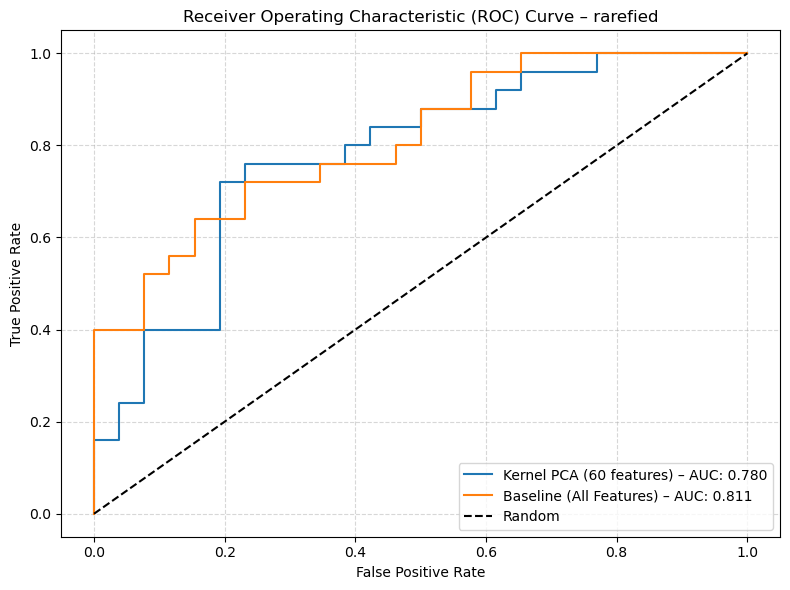

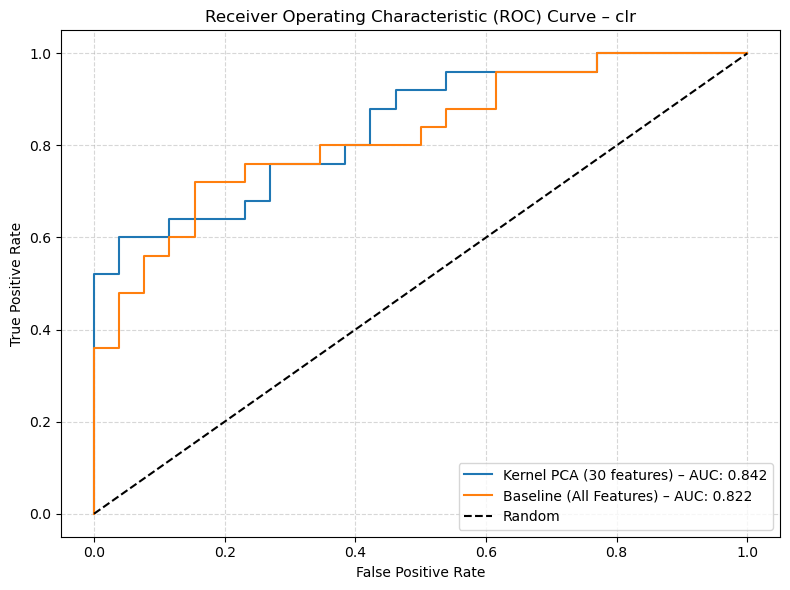

In [14]:
# finding the best method based on AUC
for ds in dataset_names:
    result = feature_eng_outputs[ds]
    y_test = result["y_test"]
    baseline_probs = result["baseline_probs"]
    selection = result["feature_selection"]
    extraction = result["feature_extraction"]
    best_model_name = result["best_model_name"]
    
    all_results = {**selection, **extraction}
    best_auc = -1
    best_probs = None
    best_method_name = ""
    
    for k, method_dict in all_results.items():
        for method, metrics in method_dict.items():
            if metrics["AUC"] > best_auc:
                best_auc = metrics["AUC"]
                best_method_name = f"{method} ({k} features)"
                best_probs = metrics["y_probs"]
    # plotting ROC curve
    plot_roc_curve(y_test, baseline_probs, best_probs, ds, best_method_name)